### Predict the probability of a customer default

#### Vasilyeu Siarhei, vasiluev@tut.by, +375 29 7731272, Skype: vasiluev@outook.com

### 1. Import libraries and load data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_curve
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import auc
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

In [3]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 100)

import warnings
warnings.simplefilter('ignore')

from pylab import rcParams
rcParams['figure.figsize'] = 12, 8

In [4]:
train = pd.read_csv("train.csv", sep=',', index_col='id')
test = pd.read_csv("test.csv", sep=',', index_col='id')

In [5]:
# Verify the correctness of the load
train.head()

,application_dt,education_cd,gender_cd,age,car_own_flg,car_type_flg,appl_rej_cnt,good_work_flg,Score_bki,out_request_cnt,region_rating,home_address_cd,work_address_cd,income,SNA,first_time_cd,Air_flg,default_flg
id,,,,,,,,,,,,,,,,,,
1,01JAN2014,SCH,M,27,Y,Y,0,0,-1.917831,0,40,2,3,32000,1,4,N,0
2,01JAN2014,GRD,F,26,N,N,0,0,-1.153144,2,60,2,3,50000,2,1,N,0
3,01JAN2014,SCH,M,35,N,N,0,1,-1.732810,0,40,1,2,20000,4,3,N,0
4,01JAN2014,GRD,F,35,N,N,0,1,-2.552133,2,20,2,3,80000,1,3,N,0
5,01JAN2014,UGR,F,24,N,N,0,0,-1.914581,1,50,2,3,27000,1,2,N,0


In [6]:
test.head()

,application_dt,education_cd,gender_cd,age,car_own_flg,car_type_flg,appl_rej_cnt,good_work_flg,Score_bki,out_request_cnt,region_rating,home_address_cd,work_address_cd,income,SNA,first_time_cd,Air_flg
id,,,,,,,,,,,,,,,,,
110149,01MAY2014,UGR,M,31,Y,Y,0,0,-2.313321,0,50,2,3,40000,1,4,N
110150,01MAY2014,SCH,M,35,N,N,0,0,-1.758973,0,80,3,3,40000,1,4,N
110151,01MAY2014,SCH,F,50,N,N,0,1,-2.580268,5,50,2,3,38000,1,3,N
110152,01MAY2014,UGR,M,35,Y,N,0,0,-2.352652,4,60,2,3,25000,4,2,N
110153,01MAY2014,UGR,M,31,Y,N,0,0,-1.899158,2,60,2,3,25000,2,3,N


In [7]:
#We have a different types of variables in datasets:
#date variable - train and test datasets do not contain the same dates, so we don't use this feature for prediction
date_var = ['application_dt']
#categorical with 2 categories
bi_categorical_var = ['gender_cd', 'car_own_flg', 'car_type_flg', 'good_work_flg', 'Air_flg']
#categorical with more than 2 categories
multi_categorical_var = ['education_cd', 'home_address_cd', 'work_address_cd']
#numerical variables
numerical_var = ['age', 'appl_rej_cnt', 'Score_bki', 'out_request_cnt', 'region_rating', 'income', 'SNA', 'first_time_cd']

### 2. Explore the data and process the missing values

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110148 entries, 1 to 110148
Data columns (total 18 columns):
application_dt     110148 non-null object
education_cd       109670 non-null object
gender_cd          110148 non-null object
age                110148 non-null int64
car_own_flg        110148 non-null object
car_type_flg       110148 non-null object
appl_rej_cnt       110148 non-null int64
good_work_flg      110148 non-null int64
Score_bki          110148 non-null float64
out_request_cnt    110148 non-null int64
region_rating      110148 non-null int64
home_address_cd    110148 non-null int64
work_address_cd    110148 non-null int64
income             110148 non-null int64
SNA                110148 non-null int64
first_time_cd      110148 non-null int64
Air_flg            110148 non-null object
default_flg        110148 non-null int64
dtypes: float64(1), int64(11), object(6)
memory usage: 16.0+ MB


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70668 entries, 110149 to 180816
Data columns (total 17 columns):
application_dt     70668 non-null object
education_cd       70423 non-null object
gender_cd          70668 non-null object
age                70668 non-null int64
car_own_flg        70668 non-null object
car_type_flg       70668 non-null object
appl_rej_cnt       70668 non-null int64
good_work_flg      70668 non-null int64
Score_bki          70668 non-null float64
out_request_cnt    70668 non-null int64
region_rating      70668 non-null int64
home_address_cd    70668 non-null int64
work_address_cd    70668 non-null int64
income             70668 non-null int64
SNA                70668 non-null int64
first_time_cd      70668 non-null int64
Air_flg            70668 non-null object
dtypes: float64(1), int64(10), object(6)
memory usage: 9.7+ MB


Both train and test datasets has a missing values in column "education_cd". Train dataset has 478 missing values (0.43 %). Test dataset has 245 Missing values (0.34 %)

#### Missing values

In [10]:
# Define the function to fill the missing values
def replace_nan(data):
    # in column 'education_cd' replace NaN на 'Uk' - 'Unknown'
    data['education_cd'] = data['education_cd'].fillna('Uk')    

In [11]:
replace_nan(train)
replace_nan(test)

#### Visualizations

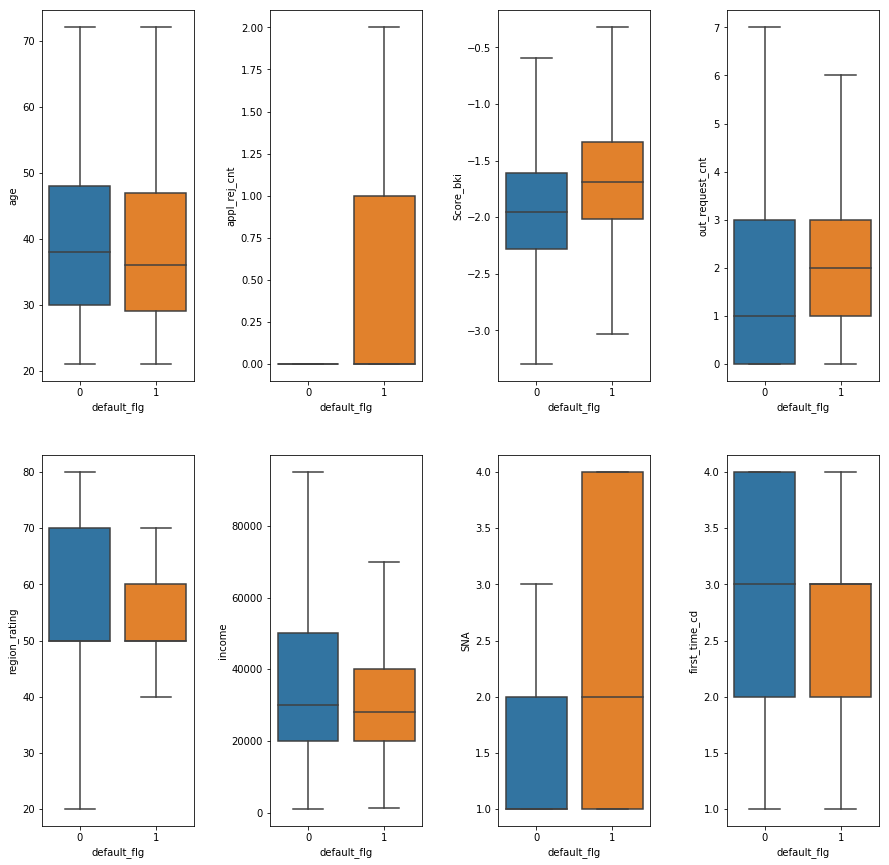

In [12]:
#visualizing numerical variables using boxplot
fig, axes = plt.subplots(2, 4, figsize=(15,15))
plt.subplots_adjust(wspace = 0.5)
axes = axes.flatten()
for i in range(len(numerical_var)):
    sns.boxplot(x="default_flg", y=numerical_var[i], data=train, orient = 'v', ax=axes[i], showfliers=False)

The customers with default_flg = 0 camparing with customers with default_flg = 1 in average:
- older
- has no past denied claims 
- has a lower Score_bki
- has lower number of requests in the bureau
- has higher income

### 3. Preparing data for machine learning

In [13]:
# For binary categoricak features we will use label encoder
le = LabelEncoder()
for n in bi_categorical_var:
    le.fit(train[n])
    train[n] = le.transform(train[n])
    test[n] = le.transform(test[n])

In [14]:
le2 = LabelEncoder()
le2.fit(train["education_cd"])
train["education_cd"] = le2.transform(train["education_cd"])
test["education_cd"] = le2.transform(test["education_cd"])

In [15]:
# For multivariant categorical features we will use one hot encoder
ohe = OneHotEncoder(sparse = False)
ohe.fit(train[multi_categorical_var])
ohe_matrix_train = pd.DataFrame(ohe.transform(train[multi_categorical_var].as_matrix()))
ohe_matrix_test = pd.DataFrame(ohe.transform(test[multi_categorical_var].as_matrix()))

In [16]:
ohe_matrix_test.index += 110149
ohe_matrix_train.index += 1

In [17]:
new_col = list(ohe_matrix_train)

In [18]:
train_data = train
test_data = test

In [19]:
train_data[new_col] = ohe_matrix_train
test_data[new_col] = ohe_matrix_test

In [20]:
features = ['gender_cd', 'car_own_flg', 'car_type_flg', 'good_work_flg', 'Air_flg', 'age', 'appl_rej_cnt', 'Score_bki', 
            'out_request_cnt', 'region_rating', 'income', 'SNA', 
            'first_time_cd', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [21]:
# Standardization of data
scaler = StandardScaler()
scaler.fit(train_data[features])
train_sc = scaler.transform(train_data[features])
test_sc = scaler.transform(test_data[features])

In [22]:
# Break train into training and test set
X_train, X_test, y_train, y_test = train_test_split(train_sc, 
                                                    train.default_flg, 
                                                    test_size=0.20, 
                                                    random_state=123)

### 4. Determine the importance of attributes using the Random Forest

Feature ranking:
1. Score_bki (0.209913)
2. age (0.170276)
3. income (0.166361)
4. out_request_cnt (0.119202)
5. region_rating (0.072885)
6. appl_rej_cnt (0.054540)
7. first_time_cd (0.047743)
8. SNA (0.037415)
9. gender_cd (0.021189)
10. car_own_flg (0.018279)
11. good_work_flg (0.015279)
12. Air_flg (0.011406)
13. car_type_flg (0.009631)
14. 3 (0.006898)
15. 7 (0.005548)
16. 11 (0.005400)
17. 1 (0.005331)
18. 4 (0.005267)
19. 6 (0.004783)
20. 10 (0.004274)
21. 9 (0.002818)
22. 2 (0.002024)
23. 8 (0.001787)
24. 5 (0.001180)
25. 0 (0.000571)


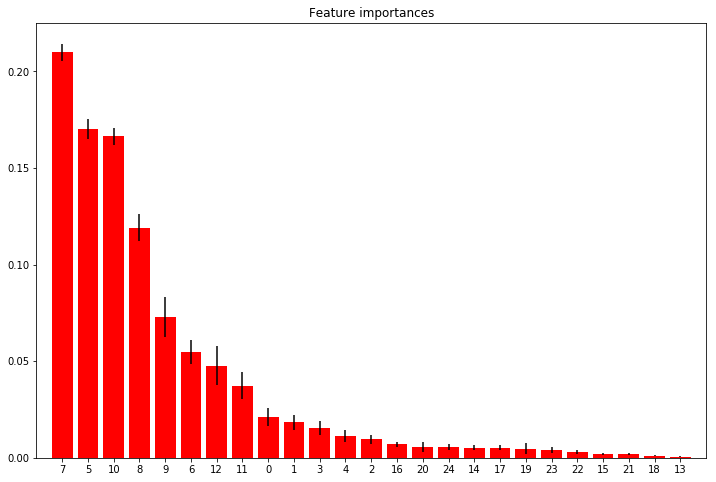

In [23]:
# estimate feature importance using Random Forest
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Features importance rank
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, list(train_data[features])[indices[f]], importances[indices[f]]))

# Features importance plot
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

As we can see, the most important features are Score_bki, age, income and out_request_cnt


### 5. Built the first model

In [24]:
# Ensemble of classifiers by Weighted Average Probabilities
clf1 = LogisticRegression(random_state=42)
clf2 = RandomForestClassifier(random_state=42)
clf3 = SGDClassifier(loss='log', random_state=42)

eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('sgd', clf3)], voting='soft', weights=[1,1,1])

In [25]:
# Quality control of the model by cross-validation with calculation of ROC AUC
for clf, label in zip([clf1, clf2, clf3, eclf], 
                      ['Logistic Regression', 'Random Forest', 'SGD', 'Ensemble']):
    scores2 = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print("ROC AUC: %0.6f (+/- %0.6f) [%s]" % (scores2.mean(), scores2.std(), label))

ROC AUC: 0.730281 (+/- 0.007790) [Logistic Regression]
ROC AUC: 0.649009 (+/- 0.007271) [Random Forest]
ROC AUC: 0.713745 (+/- 0.012893) [SGD]
ROC AUC: 0.717378 (+/- 0.007452) [Ensemble]


On the training data, the best result is provided by Logistic Regression

### 6. Tuning hyperparameters for logistic regression

In [26]:
lr_cv = LogisticRegressionCV(penalty='l2', solver='lbfgs', refit=True)
lr_cv.fit(X_train, y_train)
print("Selected value of c parameter: ", lr_cv.C_)
print("Accuracy:", lr_cv.score(X_train, y_train))

Selected value of c parameter:  [0.00077426]
Accuracy: 0.8734878231462357


In [27]:
scores_lr = cross_val_score(estimator=lr_cv, X=X_train, y=y_train, cv=10, scoring='roc_auc')
print("ROC AUC: %0.6f (+/- %0.6f)" % (scores_lr.mean(), scores_lr.std()))

ROC AUC: 0.730313 (+/- 0.007586)


### 7. Visualizing datasets with PCA

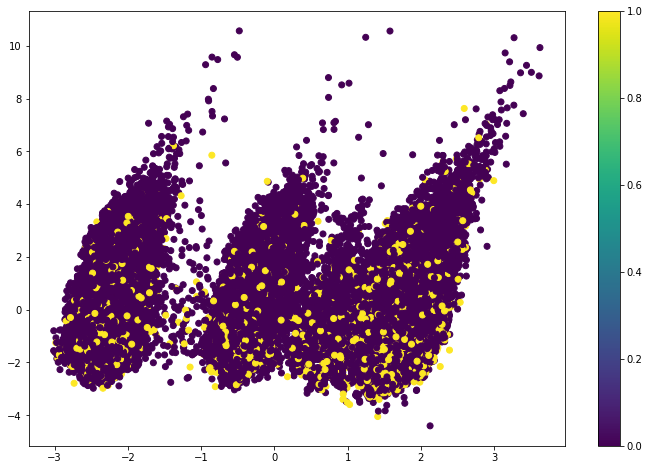

In [28]:
#Visualizing train dataset with PCA
pca = PCA(n_components=2)
proj = pca.fit_transform(X_train)
plt.scatter(proj[:, 0], proj[:, 1], c=y_train)
plt.colorbar()

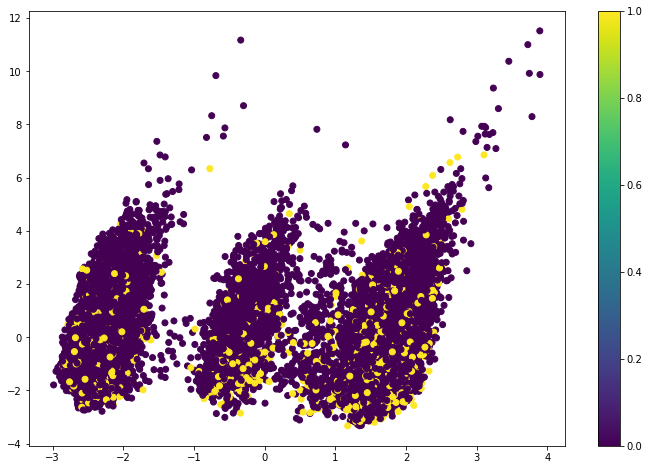

In [34]:
#Visualizing test dataset with PCA
pca2 = PCA(n_components=2)
proj2 = pca2.fit_transform(X_test)
plt.scatter(proj2[:, 0], proj2[:, 1], c=y_test)
plt.colorbar()

### 8. Building a classifier based on test data

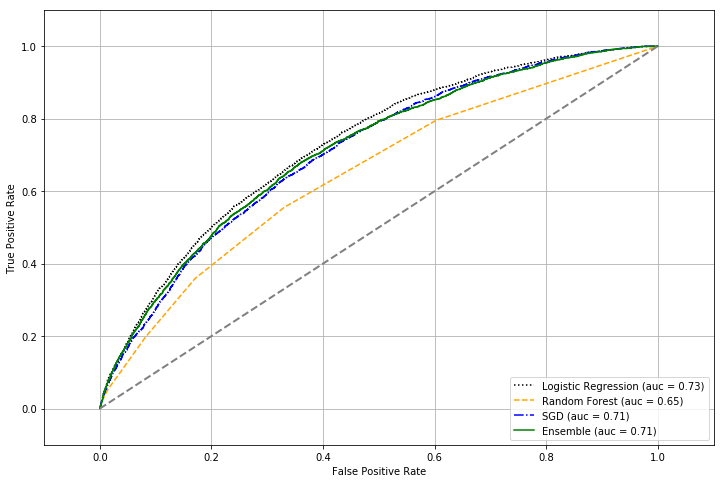

In [29]:
# roc curve on test data
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls in zip([lr_cv, clf2, clf3, eclf], 
                               ['Logistic Regression', 'Random Forest', 'SGD', 'Ensemble'], 
                               colors, linestyles):
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label='%s (auc = %0.2f)' % (label, roc_auc))
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

The ROC AUC values obtained for the cross validation and for the test sample are the same, which indicates that the model is not overfitted and not underfitted.

In [33]:
y_pred = lr_cv.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[19169,    61],
       [ 2748,    52]], dtype=int64)

### 9. Getting the final result

In [37]:
result_pred = lr_cv.fit(train_sc, train.default_flg).predict_proba(test_sc)
result = pd.DataFrame(test.index)
result['Default_probability'] = list(result_pred[:, 1])
result.to_csv('result.csv', encoding='utf8', index=None)

In [38]:
result.head(50)

,id,Default_probability
0,110149,0.083010
1,110150,0.067622
2,110151,0.085129
3,110152,0.163110
4,110153,0.153411
5,110154,0.220081
6,110155,0.130443
7,110156,0.121599
8,110157,0.190285
9,110158,0.123603
